# Cora Graph Neural Networks
Set up the Cora citation dataset and define baseline GNN models using the custom layers in `models.py`.

## Imports
Bring in PyTorch, PyG utilities, and the custom layers from `models.py` reused throughout the notebook.

In [1]:
import torch
from torch import nn
from torch.nn import functional as F
from torch_geometric.datasets import Planetoid
from torch_geometric.utils import add_self_loops, to_dense_adj
from torch_geometric.explain import Explainer, ModelConfig, GNNExplainer
from models import GCN, GraphSAGE
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from sklearn.manifold import TSNE
import networkx as nx
from typing import List, Optional

/Users/hehvince/Desktop/FYP/FYP_Interpretable_Explanations/.venv/lib/python3.14/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Dataset Preparation
Load the Cora citation graph, move data to the chosen device, and build dense adjacency/features for the custom layer interface.

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dataset = Planetoid(root="./data/Planetoid", name="Cora")
data = dataset[0].to(device)

# Prepare edge index with self-loops plus convenience tensors
edge_index, _ = add_self_loops(data.edge_index, num_nodes=data.num_nodes)
data.edge_index = edge_index
adjacency = to_dense_adj(edge_index, max_num_nodes=data.num_nodes)[0].to(device)
features = data.x.to(device)
labels = data.y.to(device)

in_feats = features.size(-1)
num_classes = dataset.num_classes

# Provide a dummy batch vector so pooled models operate on the single graph
data.batch = torch.zeros(data.num_nodes, dtype=torch.long, device=device)

cora_class_names = [
    "Case_Based",
    "Genetic_Algorithms",
    "Neural_Networks",
    "Probabilistic_Methods",
    "Reinforcement_Learning",
    "Rule_Learning",
    "Theory",
]
label_ids = sorted(labels.cpu().unique().tolist())
label_name_map = {idx: cora_class_names[idx] for idx in label_ids}

print(dataset)
print(f"Feature matrix: {features.shape}, adjacency: {adjacency.shape}")
print(f"Nodes: {data.num_nodes}, Features per node: {dataset.num_features}, Classes: {dataset.num_classes}")
print("Unique class labels:", label_name_map)

Cora()
Feature matrix: torch.Size([2708, 1433]), adjacency: torch.Size([2708, 2708])
Nodes: 2708, Features per node: 1433, Classes: 7
Unique class labels: {0: 'Case_Based', 1: 'Genetic_Algorithms', 2: 'Neural_Networks', 3: 'Probabilistic_Methods', 4: 'Reinforcement_Learning', 5: 'Rule_Learning', 6: 'Theory'}


## Instantiate and Inspect Models
Create the custom GCN and provided GraphSAGE, run dry forwards, and confirm output dimensions.

In [3]:
gcn_model = GCN(num_features=dataset.num_features, hidden_channels=64, num_classes=dataset.num_classes).to(device)
graphsage_model = GraphSAGE(dataset=dataset, num_layers=2, hidden=64, dropout=0.5).to(device)

gcn_model.eval()
graphsage_model.eval()

with torch.no_grad():
    gcn_logits = gcn_model(data.x, data.edge_index)
    graphsage_logits = graphsage_model(data)

print(f"GCN output shape: {gcn_logits.shape}")
print(f"GraphSAGE output shape: {graphsage_logits.shape}")

GCN output shape: torch.Size([2708, 7])
GraphSAGE output shape: torch.Size([2708, 7])


## Embedding Visualisation Helpers
Project model outputs into 2D via t-SNE for before/after comparisons.

In [4]:
def tsne_project(tensor: torch.Tensor, perplexity: float = 30.0, random_state: int = 42) -> torch.Tensor:
    embedding_np = tensor.detach().cpu().numpy()
    tsne = TSNE(
        n_components=2,
        perplexity=perplexity,
        init="pca",
        learning_rate="auto",
        random_state=random_state,
    )
    coords = tsne.fit_transform(embedding_np)
    return torch.from_numpy(coords).float()

def plot_embeddings(coords_gcn, coords_sage, title_suffix: str):
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    labels_cpu = labels.cpu()
    for ax, coords, model_name in zip(
        axes,
        (coords_gcn, coords_sage),
        ("GCN", "GraphSAGE"),
    ):
        ax.scatter(
            coords[:, 0],
            coords[:, 1],
            c=labels_cpu,
            cmap="tab10",
            s=10,
            alpha=0.8,
        )
        ax.set_title(f"{model_name} {title_suffix}")
        ax.set_xlabel("Component 1")
        ax.set_ylabel("Component 2")
    cmap = plt.cm.get_cmap("tab10", len(label_name_map))
    handles = [
        Line2D([0], [0], marker="o", color="w", markerfacecolor=cmap(class_id), markersize=6)
        for class_id in sorted(label_name_map)
    ]
    axes[-1].legend(
        handles,
        [label_name_map[idx] for idx in sorted(label_name_map)],
        title="Classes",
        bbox_to_anchor=(1.05, 1),
        loc="upper left",
    )
    plt.tight_layout()
    plt.show()

## Pre-Training Embedding Snapshot
Visualise random-initialised model outputs with t-SNE before any optimisation.

C:\Users\Vince\AppData\Local\Temp\ipykernel_23804\2766157793.py:32: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("tab10", len(label_name_map))


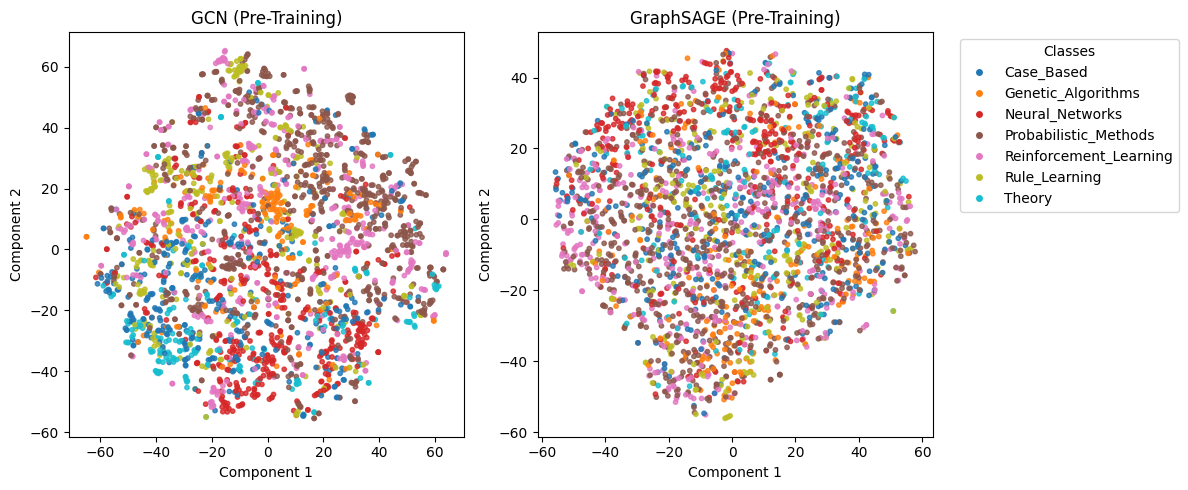

In [5]:
with torch.no_grad():
    gcn_model.eval()
    graphsage_model.eval()
    pre_gcn_logits = gcn_model(data.x, data.edge_index)
    pre_sage_logits = graphsage_model(data)

pre_gcn_coords = tsne_project(pre_gcn_logits)
pre_sage_coords = tsne_project(pre_sage_logits)
plot_embeddings(pre_gcn_coords, pre_sage_coords, "(Pre-Training)")

## Training Utilities
Set up loss functions, optimizers, and helper routines to train and evaluate both models.

In [6]:
loss_fn = nn.CrossEntropyLoss()

train_mask = data.train_mask
val_mask = data.val_mask
test_mask = data.test_mask

gcn_optimizer = torch.optim.Adam(gcn_model.parameters(), lr=0.01, weight_decay=5e-4)
graphsage_optimizer = torch.optim.Adam(graphsage_model.parameters(), lr=0.01, weight_decay=5e-4)

def train_gcn() -> tuple[float, float]:
    gcn_model.train()
    gcn_optimizer.zero_grad()
    logits = gcn_model(data.x, data.edge_index)
    loss = loss_fn(logits[train_mask], labels[train_mask])
    loss.backward()
    gcn_optimizer.step()
    preds = logits.argmax(dim=-1)
    train_acc = (preds[train_mask] == labels[train_mask]).float().mean().item()
    return loss.item(), train_acc

def train_graphsage() -> tuple[float, float]:
    graphsage_model.train()
    graphsage_optimizer.zero_grad()
    logits = graphsage_model(data)
    loss = loss_fn(logits[train_mask], labels[train_mask])
    loss.backward()
    graphsage_optimizer.step()
    preds = logits.argmax(dim=-1)
    train_acc = (preds[train_mask] == labels[train_mask]).float().mean().item()
    return loss.item(), train_acc

@torch.no_grad()
def evaluate_gcn(mask: torch.Tensor):
    gcn_model.eval()
    logits = gcn_model(data.x, data.edge_index)
    preds = logits.argmax(dim=-1)
    loss = loss_fn(logits[mask], labels[mask])
    acc = (preds[mask] == labels[mask]).float().mean().item()
    return loss.item(), acc, preds

@torch.no_grad()
def evaluate_graphsage(mask: torch.Tensor):
    graphsage_model.eval()
    logits = graphsage_model(data)
    preds = logits.argmax(dim=-1)
    loss = loss_fn(logits[mask], labels[mask])
    acc = (preds[mask] == labels[mask]).float().mean().item()
    return loss.item(), acc, preds

## Train Models
Run a joint training loop and monitor validation loss/accuracy for both architectures.

In [7]:
gcn_epochs = 1000
for epoch in range(1, gcn_epochs + 1):
    gcn_loss, gcn_train_acc = train_gcn()
    if epoch == 1 or epoch % 20 == 0 or epoch == gcn_epochs:
        gcn_val_loss, gcn_val_acc, _ = evaluate_gcn(val_mask)
        print(
            f"[GCN] Epoch {epoch:03d} | "
            f"train {gcn_loss:.4f} (acc {gcn_train_acc:.4f}) / "
            f"val {gcn_val_loss:.4f} (acc {gcn_val_acc:.4f})"
        )

graphsage_epochs = 1000
for epoch in range(1, graphsage_epochs + 1):
    sage_loss, sage_train_acc = train_graphsage()
    if epoch == 1 or epoch % 20 == 0 or epoch == graphsage_epochs:
        sage_val_loss, sage_val_acc, _ = evaluate_graphsage(val_mask)
        print(
            f"[GraphSAGE] Epoch {epoch:03d} | "
            f"train {sage_loss:.4f} (acc {sage_train_acc:.4f}) / "
            f"val {sage_val_loss:.4f} (acc {sage_val_acc:.4f})"
        )

[GCN] Epoch 001 | train 2.0931 (acc 0.1429) / val 1.9657 (acc 0.1140)
[GCN] Epoch 020 | train 0.1543 (acc 0.9643) / val 1.0664 (acc 0.6720)
[GCN] Epoch 020 | train 0.1543 (acc 0.9643) / val 1.0664 (acc 0.6720)
[GCN] Epoch 040 | train 0.0366 (acc 0.9929) / val 1.4277 (acc 0.6460)
[GCN] Epoch 040 | train 0.0366 (acc 0.9929) / val 1.4277 (acc 0.6460)
[GCN] Epoch 060 | train 0.0195 (acc 0.9929) / val 1.5055 (acc 0.6540)
[GCN] Epoch 060 | train 0.0195 (acc 0.9929) / val 1.5055 (acc 0.6540)
[GCN] Epoch 080 | train 0.0370 (acc 0.9929) / val 1.5432 (acc 0.6580)
[GCN] Epoch 080 | train 0.0370 (acc 0.9929) / val 1.5432 (acc 0.6580)
[GCN] Epoch 100 | train 0.0211 (acc 0.9929) / val 1.5291 (acc 0.6700)
[GCN] Epoch 100 | train 0.0211 (acc 0.9929) / val 1.5291 (acc 0.6700)
[GCN] Epoch 120 | train 0.0156 (acc 1.0000) / val 1.6717 (acc 0.6440)
[GCN] Epoch 120 | train 0.0156 (acc 1.0000) / val 1.6717 (acc 0.6440)
[GCN] Epoch 140 | train 0.0047 (acc 1.0000) / val 1.5751 (acc 0.6720)
[GCN] Epoch 140 | tr

## Evaluate on Test Set
Measure final performance and compare a handful of predicted labels against the ground truth.

In [8]:
gcn_test_loss, gcn_test_acc, gcn_preds = evaluate_gcn(test_mask)
sage_test_loss, sage_test_acc, sage_preds = evaluate_graphsage(test_mask)

print(f"GCN test loss {gcn_test_loss:.4f}, accuracy {gcn_test_acc:.4f}")
print(f"GraphSAGE test loss {sage_test_loss:.4f}, accuracy {sage_test_acc:.4f}")

test_indices = test_mask.nonzero(as_tuple=False).view(-1)
sample_count = min(10, test_indices.numel())
sample_indices = test_indices[:sample_count]

if sample_count == 0:
    print("No test nodes available in the current split.")
else:
    print("\nSample predictions on test nodes:")
    for idx in sample_indices:
        idx_int = int(idx.item())
        true_label = int(labels[idx].item())
        gcn_label = int(gcn_preds[idx].item())
        sage_label = int(sage_preds[idx].item())
        print(
            f"Node {idx_int:4d} | True: {true_label} | "
            f"GCN: {gcn_label} | GraphSAGE: {sage_label}"
        )

GCN test loss 1.9393, accuracy 0.6710
GraphSAGE test loss 0.7806, accuracy 0.7690

Sample predictions on test nodes:
Node 1708 | True: 3 | GCN: 1 | GraphSAGE: 1
Node 1709 | True: 2 | GCN: 2 | GraphSAGE: 2
Node 1710 | True: 2 | GCN: 1 | GraphSAGE: 2
Node 1711 | True: 2 | GCN: 2 | GraphSAGE: 2
Node 1712 | True: 2 | GCN: 2 | GraphSAGE: 2
Node 1713 | True: 0 | GCN: 1 | GraphSAGE: 6
Node 1714 | True: 2 | GCN: 2 | GraphSAGE: 2
Node 1715 | True: 2 | GCN: 2 | GraphSAGE: 2
Node 1716 | True: 2 | GCN: 2 | GraphSAGE: 2
Node 1717 | True: 2 | GCN: 2 | GraphSAGE: 2


## GNN Explainer Interpretability
Use GNN Explainer to visualise influential subgraphs for sample predictions and quantify explanation quality.

In [ ]:
def _normalize_node_mask(node_mask, x: torch.Tensor, node_idx: int) -> torch.Tensor:
    if node_mask is None:
        return torch.ones_like(x)
    if node_mask.dim() == 2:
        if node_mask.shape == x.shape:
            return node_mask
        if node_mask.size(0) == x.size(0) and node_mask.size(1) == 1:
            return node_mask.repeat(1, x.size(-1))
    if node_mask.dim() == 1:
        if node_mask.numel() == x.size(-1):
            expanded = torch.ones_like(x)
            expanded[node_idx] = node_mask
            return expanded
        if node_mask.numel() == x.size(0):
            return node_mask.unsqueeze(-1).repeat(1, x.size(-1))
    if node_mask.dim() == 2 and node_mask.size(1) == x.size(-1):
        return node_mask
    return torch.ones_like(x)

def _build_target_tensor(node_idx: int, data, labels: torch.Tensor, model: torch.nn.Module) -> tuple[torch.Tensor, int]:
    """Build target tensor based on model's actual prediction, not ground truth."""
    with torch.no_grad():
        logits = model(data.x, data.edge_index)
        predicted_class = int(logits[node_idx].argmax().item())
    
    target_tensor = torch.full(
        (data.num_nodes,),
        predicted_class,
        dtype=labels.dtype,
        device=labels.device,
    )
    return target_tensor, predicted_class

def _prepare_edge_subset(
    edge_index: torch.Tensor,
    edge_mask: torch.Tensor,
    selection: torch.Tensor,
    max_edges: Optional[int] = None,
) -> tuple[torch.Tensor, torch.Tensor]:
    selected_idx = selection.nonzero(as_tuple=False).view(-1)
    if selected_idx.numel() == 0:
        selected_idx = edge_mask.topk(1).indices
    if max_edges is not None and selected_idx.numel() > max_edges:
        mask_values = edge_mask[selected_idx]
        topk = mask_values.topk(max_edges).indices
        selected_idx = selected_idx[topk]
    sub_edge_index = edge_index[:, selected_idx]
    sub_edge_mask = edge_mask[selected_idx]
    return sub_edge_index, sub_edge_mask

def _plot_explanation(
    node_idx: int,
    edge_index: torch.Tensor,
    edge_mask: torch.Tensor,
    selection: torch.Tensor,
    ax: plt.Axes,
    max_edges: Optional[int] = 20,
):
    sub_edge_index, sub_edge_mask = _prepare_edge_subset(
        edge_index, edge_mask, selection, max_edges=max_edges
    )
    sub_edge_index = sub_edge_index.detach().cpu()
    sub_edge_mask = sub_edge_mask.detach().cpu()

    graph = nx.Graph()
    edges = sub_edge_index.t().tolist()
    weights = sub_edge_mask.tolist() if sub_edge_mask.numel() > 0 else []
    nodes = set()
    for idx, (src, dst) in enumerate(edges):
        weight = weights[idx] if idx < len(weights) else 0.0
        graph.add_edge(src, dst, weight=float(weight))
        nodes.add(src)
        nodes.add(dst)
    nodes.add(node_idx)
    graph.add_nodes_from(nodes)

    if node_idx not in graph:
        graph.add_node(node_idx)

    for node in graph.nodes():
        label_val = int(labels[node].item())
        graph.nodes[node]["label"] = label_name_map.get(label_val, str(label_val))

    pos = nx.spring_layout(graph, seed=42)
    node_colors = ["#ff7f0e" if node == node_idx else "#1f77b4" for node in graph.nodes()]

    nx.draw_networkx_nodes(
        graph,
        pos,
        node_color=node_colors,
        node_size=300,
        alpha=0.9,
        ax=ax,
    )
    if graph.number_of_edges() > 0:
        edge_weights = [max(float(data.get("weight", 0.0)), 0.0) for _, _, data in graph.edges(data=True)]
        w_min = min(edge_weights)
        w_max = max(edge_weights)
        if w_max - w_min < 1e-9:
            norm_vals = [0.5 for _ in edge_weights]
        else:
            norm_vals = [(w - w_min) / (w_max - w_min) for w in edge_weights]
        edge_colors = [plt.cm.Reds(v) for v in norm_vals]
        edge_widths = [1.5 + 2.5 * v for v in norm_vals]
        nx.draw_networkx_edges(
            graph,
            pos,
            edge_color=edge_colors,
            width=edge_widths,
            ax=ax,
        )
    nx.draw_networkx_labels(
        graph,
        pos,
        labels={n: graph.nodes[n]["label"] for n in graph.nodes()},
        font_size=8,
        ax=ax,
    target_tensor, predicted_class = _build_target_tensor(node_idx, data, labels, model)
    ax.set_axis_off()

def run_gnn_explainer(model: torch.nn.Module, node_idx: int, data, epochs: int = 200):
    model.eval()
    target_tensor = _build_target_tensor(node_idx, data, labels)
    explainer = Explainer(
        model=model,
        algorithm=GNNExplainer(epochs=epochs),
        explanation_type="phenomenon",
        model_config=ModelConfig(
            mode="multiclass_classification",
            task_level="node",
            return_type="raw",
        ),
        node_mask_type="attributes",
        edge_mask_type="object",
    )
    explanation = explainer(
        data.x,
        data.edge_index,
        index=node_idx,
        target=target_tensor,
    )
    return explainer, explanation, node_feat_mask, edge_mask, predicted_class
    if edge_mask is None:
        edge_mask = torch.zeros(data.edge_index.size(1), device=data.edge_index.device)
    node_feat_mask = _normalize_node_mask(explanation.node_mask, data.x, node_idx).to(data.x.device)
    edge_mask = edge_mask.to(data.edge_index.device)
    return explainer, explanation, node_feat_mask, edge_mask

def build_edge_selection(edge_mask: torch.Tensor) -> torch.Tensor:
    if edge_mask.numel() == 0:
        return torch.zeros_like(edge_mask, dtype=torch.bool)
    threshold = edge_mask.mean()
    return (edge_mask >= threshold).to(torch.bool)

def compute_explanation_metrics(
    model: torch.nn.Module,
    data,
    node_idx: int,
    node_feat_mask: torch.Tensor,
    edge_mask: torch.Tensor,
    true_class = int(labels[node_idx].item())
    is_correct = (target_class == true_class)
    
    with torch.no_grad():
        logits = model(x, edge_index)
        probs = logits.softmax(dim=-1)
        full_prob = float(probs[node_idx, target_class].item())

        masked_x = x * node_feat_mask
        masked_edge_index, _ = _prepare_edge_subset(edge_index, edge_mask, selection)
        masked_logits = model(masked_x, masked_edge_index)
        masked_probs = masked_logits.softmax(dim=-1)
        masked_prob = float(masked_probs[node_idx, target_class].item())

    fidelity_raw = masked_prob / (full_prob + 1e-9) if full_prob > 0 else float("nan")
    clipped_denominator = max(full_prob, 1e-4)
    fidelity_bounded = min(masked_prob / clipped_denominator, 1.0)
    prob_gain = masked_prob - full_prob
    sparsity = 1.0 - float(selection.float().mean().item())
    edge_keep = float(selection.float().mean().item())

    return {
        "predicted_class": target_class,
        "true_class": true_class,
        "is_correct": is_correct,
        "full_prob": full_prob,
        "masked_prob": masked_prob,
        "fidelity": fidelity_raw,
        "fidelity_bounded": fidelity_bounded,
        "prob_gain": prob_gain,
        "sparsity": sparsity,
        "edge_fraction_kept": edge_keep,
    }

def estimate_stability(
    model: torch.nn.Module,
    target_tensor, _ = _build_target_tensor(node_idx, data, labels, model)
    node_idx: int,
    runs: int = 3,
) -> float:
    edge_masks: List[torch.Tensor] = []
    target_tensor = _build_target_tensor(node_idx, data, labels)
    x, edge_index = data.x, data.edge_index
    cpu_state = torch.get_rng_state()
    cuda_states = torch.cuda.get_rng_state_all() if torch.cuda.is_available() else None
    try:
        for seed in range(runs):
            torch.manual_seed(seed)
            if torch.cuda.is_available():
                torch.cuda.manual_seed_all(seed)
            explainer = Explainer(
                model=model,
                algorithm=GNNExplainer(epochs=100),
                explanation_type="phenomenon",
                model_config=ModelConfig(
                    mode="multiclass_classification",
                    task_level="node",
                    return_type="raw",
                ),
                node_mask_type="attributes",
                edge_mask_type="object",
            )
            explanation = explainer(
                x,
                edge_index,
                index=node_idx,
                target=target_tensor,
            )
            mask = explanation.edge_mask
            if mask is None:
                mask = torch.zeros(edge_index.size(1), device=x.device)
            edge_masks.append(mask.to(x.device))
    finally:
        torch.set_rng_state(cpu_state)
        if cuda_states is not None:
            torch.cuda.set_rng_state_all(cuda_states)


    if not edge_masks:
    if not edge_masks:    return stability

        return float("nan")
        return float("nan")    return stability

    stacked = torch.stack(edge_masks)
    stacked = torch.stack(edge_masks)    stability = 1.0 - float(stacked.var(dim=0).mean().item())
    stability = 1.0 - float(stacked.var(dim=0).mean().item())

In [ ]:
def explain_and_report(
    model: torch.nn.Module,
    model_name: str,
    data,
    node_idx: int,
    runs: int = 3,
    max_edges: int = 20,
) -> dict:
    explainer, explanation, node_feat_mask, edge_mask, predicted_class = run_gnn_explainer(model, node_idx, data)
    selection = build_edge_selection(edge_mask)
    metrics = compute_explanation_metrics(
        model,
        data,
        node_idx,
        node_feat_mask,
        edge_mask,
        selection,
        predicted_class,
    )
    metrics["stability"] = estimate_stability(model, data, node_idx, runs=runs)

    fig, ax = plt.subplots(figsize=(6, 6))
    _plot_explanation(
        node_idx=node_idx,
        edge_index=data.edge_index,
        edge_mask=edge_mask,
        selection=selection,
        ax=ax,
        max_edges=max_edges,
    )
    ax.set_title(f"{model_name} explanation (node {node_idx})")
    plt.show()

    print(f"{model_name} metrics for node {node_idx}:")
    print(f"  predicted_class: {metrics['predicted_class']} ({label_name_map[metrics['predicted_class']]})")
    print(f"  true_class: {metrics['true_class']} ({label_name_map[metrics['true_class']]})")
    print(f"  is_correct: {metrics['is_correct']}")
    for key, value in metrics.items():
        if key not in ['predicted_class', 'true_class', 'is_correct']:
            print(f"  {key}: {value:.4f}")

    return {
        "explanation": explanation,
        "node_feat_mask": node_feat_mask,
        "edge_mask": edge_mask,
        "metrics": metrics,
    }

Explaining node 1708 with label 3


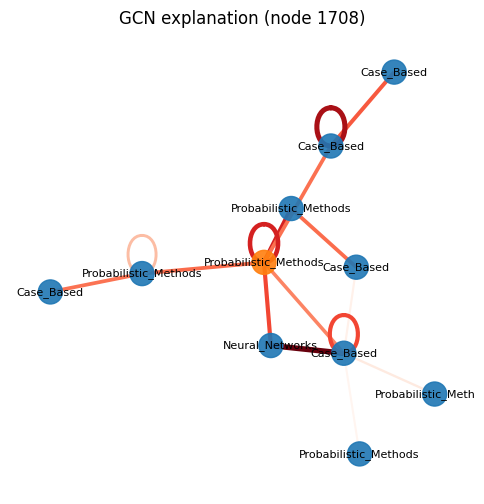

GCN metrics for node 1708:
  target_class: 3.0000
  full_prob: 0.0000
  masked_prob: 0.9998
  fidelity: 67755.6506
  fidelity_bounded: 1.0000
  prob_gain: 0.9998
  sparsity: 0.7575
  edge_fraction_kept: 0.2425
  stability: 1.0000


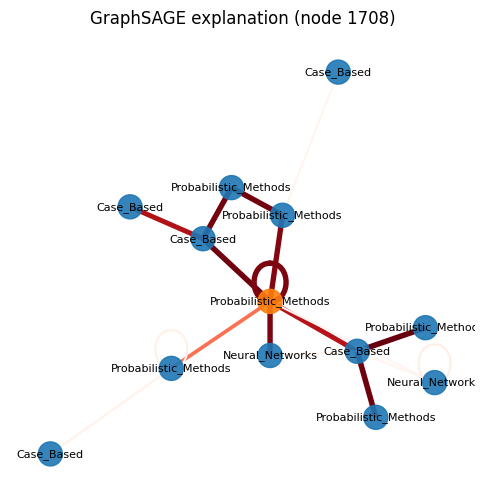

GraphSAGE metrics for node 1708:
  target_class: 3.0000
  full_prob: 0.0683
  masked_prob: 0.6882
  fidelity: 10.0736
  fidelity_bounded: 1.0000
  prob_gain: 0.6199
  sparsity: 0.9851
  edge_fraction_kept: 0.0149
  stability: 1.0000


In [42]:
test_nodes = test_mask.nonzero(as_tuple=False).view(-1)
if test_nodes.numel() == 0:
    raise ValueError("No test nodes available for explanation.")
sample_node = int(test_nodes[0].item())
print(f"Explaining node {sample_node} with label {int(labels[sample_node].item())}")

gcn_explanation = explain_and_report(gcn_model, "GCN", data, sample_node)
graphsage_explanation = explain_and_report(graphsage_model, "GraphSAGE", data, sample_node)

## Post-Training Embedding Snapshot
Repeat the projection with t-SNE after optimisation to show class separation.

C:\Users\Vince\AppData\Local\Temp\ipykernel_23804\2766157793.py:32: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("tab10", len(label_name_map))


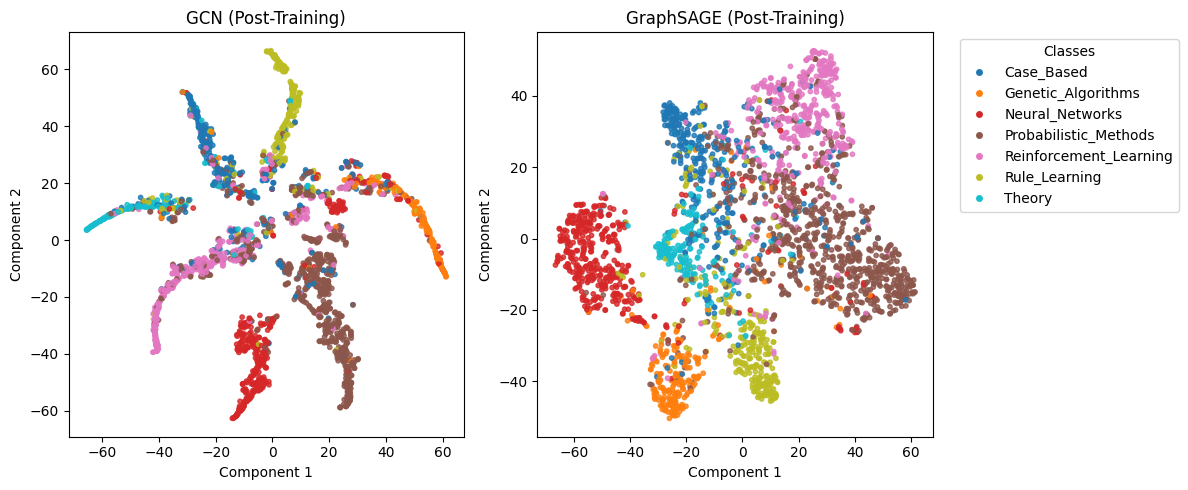

In [33]:
with torch.no_grad():
    gcn_model.eval()
    graphsage_model.eval()
    post_gcn_logits = gcn_model(data.x, data.edge_index)
    post_sage_logits = graphsage_model(data)

post_gcn_coords = tsne_project(post_gcn_logits)
post_sage_coords = tsne_project(post_sage_logits)
plot_embeddings(post_gcn_coords, post_sage_coords, "(Post-Training)")